In [2]:
import pandas as pd
from glob import glob

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from geoletrld.model import Geolet
from geoletrld.selectors import RandomSelector, MutualInformationSelector, SelectorPipeline, ClusteringSelector, \
    GapSelector
from geoletrld.utils import Trajectories, y_from_df
from geoletrld.partitioners import NoPartitioner, GeohashPartitioner, FeaturePartitioner, SlidingWindowPartitioner
from geoletrld.distances import (EuclideanDistance, InterpolatedTimeDistance, LCSSTrajectoryDistance, FrechetDistance,
                                 CaGeoDistance, MatchComputeDistance)
from sklearn_extra.cluster import KMedoids

/home/clandi/miniconda3/envs/Understanding-Geolets/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def benchmark(df: pd.DataFrame):
    df = df[["tid", "y", "time", "lat", "lon"]]

    trajectories = Trajectories.from_DataFrame(df, latitude="lat", longitude="lon", time="time")
    y = y_from_df(df, tid_name="tid", y_name="y")

    X_train, X_test, y_train, y_test = train_test_split(list(trajectories), y, test_size=0.3, random_state=32,
                                                        stratify=y)

    X_train = Trajectories([(k, trajectories[k]) for k in X_train])
    X_test = Trajectories([(k, trajectories[k]) for k in X_test])

    classifier = Geolet(
        partitioner=SlidingWindowPartitioner(window_size=50, verbose=True),
        selector=SelectorPipeline(
            RandomSelector(k=1000),
            MutualInformationSelector(n_jobs=8, k=10, distance=InterpolatedTimeDistance(n_jobs=8), verbose=True),
            # GapSelector(k=10, n_jobs=10, distance=MatchComputeDistance(EuclideanDistance(), LCSSTrajectoryDistance())),
             #ClusteringSelector(
             #KMeans(n_clusters=5), #è sbagliato?, ma funziona stranamente bene
             #KMedoids(n_clusters=3, metric='precomputed'),# n_jobs=9
            # AffinityPropagation(affinity="precomputed"), agg=lambda x: -np.sum(x),
            # OPTICS(metric="precomputed"),
            # SpectralClustering(affinity="precomputed"), agg=lambda x: -np.sum(x), #non gira
            # distance=LCSSTrajectoryDistance(n_jobs=10, verbose=True)
             #)
        ),
        distance=InterpolatedTimeDistance(n_jobs=8, verbose=True),
        model_to_fit=RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=32),
        # model_to_fit=KMeans(n_clusters=2)
        verbose=True,
        
    ).fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))

In [10]:
rename_map = {
    "vehicle_id": "tid",
    "class": "y"
}

df = pd.read_csv("../generation/sumo_stuff/Grid-Empire-2.5km/trajectories.zip").rename(columns=rename_map)

df.head()

,tid,lon,lat,time,y
0,veh0,-73.997363,40.761999,2.0,passenger
1,veh0,-73.997372,40.761964,3.0,passenger
2,veh0,-73.997404,40.761918,4.0,passenger
3,veh0,-73.997448,40.761859,5.0,passenger
4,veh0,-73.997503,40.761785,6.0,passenger
...,...,...,...,...,...
2259795,veh999,-73.966891,40.752557,1554.0,bicycle
2259796,veh999,-73.966865,40.752600,1555.0,bicycle
2259797,veh999,-73.966842,40.752643,1556.0,bicycle
2259798,veh999,-73.966821,40.752683,1557.0,bicycle


<Axes: >

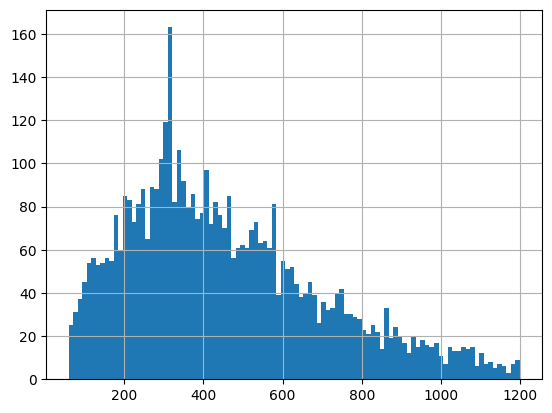

In [18]:
df_count = df.groupby("tid").size()
df_count = df_count[(df_count > 60) & (df_count < 60*20)]

df_count.hist(bins=100)


In [21]:
df[df.tid.isin(df_count.keys())]

,tid,lon,lat,time,y
0,veh0,-73.997363,40.761999,2.0,passenger
1,veh0,-73.997372,40.761964,3.0,passenger
2,veh0,-73.997404,40.761918,4.0,passenger
3,veh0,-73.997448,40.761859,5.0,passenger
4,veh0,-73.997503,40.761785,6.0,passenger
...,...,...,...,...,...
2259795,veh999,-73.966891,40.752557,1554.0,bicycle
2259796,veh999,-73.966865,40.752600,1555.0,bicycle
2259797,veh999,-73.966842,40.752643,1556.0,bicycle
2259798,veh999,-73.966821,40.752683,1557.0,bicycle


## CV results

In [4]:
df = pd.read_csv("results/scores_cv/results.csv").drop(columns=["n_jobs"])

df

,accuracy,balanced_accuracy,f1_score,f1_micro,f1_macro,f1_weighted,precision_score,precision_micro,precision_macro,precision_weighted,...,n_geo_factor,n_geo_,selection,distance,n_classes,max_depth,class_weight,model,n_estimators,n_neighbors
0,0.708333,0.708333,0.758621,0.708333,0.695100,0.695100,0.647059,0.708333,0.752101,0.752101,...,10,20,random,ED,2,1.0,balanced,DT,NaN,NaN
1,0.729167,0.729167,0.697674,0.729167,0.726196,0.726196,0.789474,0.729167,0.739564,0.739564,...,10,20,random,ED,2,2.0,balanced,DT,NaN,NaN
2,0.770833,0.770833,0.792453,0.770833,0.768319,0.768319,0.724138,0.770833,0.783122,0.783122,...,10,20,random,ED,2,3.0,balanced,DT,NaN,NaN
3,0.875000,0.875000,0.884615,0.875000,0.874126,0.874126,0.821429,0.875000,0.885714,0.885714,...,10,20,random,ED,2,4.0,balanced,DT,NaN,NaN
4,0.875000,0.875000,0.880000,0.875000,0.874783,0.874783,0.846154,0.875000,0.877622,0.877622,...,10,20,random,ED,2,5.0,balanced,DT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26267,0.805556,0.805556,0.805556,0.805556,0.807240,0.807240,0.805556,0.805556,0.831123,0.831123,...,20,60,mi,ED,3,NaN,balanced,RF,1000.0,NaN
26268,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,...,20,60,mi,ED,3,NaN,NaN,KNN,NaN,3.0
26269,0.583333,0.583333,0.583333,0.583333,0.578760,0.578760,0.583333,0.583333,0.578675,0.578675,...,20,60,mi,ED,3,NaN,NaN,KNN,NaN,5.0
26270,0.597222,0.597222,0.597222,0.597222,0.590299,0.590299,0.597222,0.597222,0.592929,0.592929,...,20,60,mi,ED,3,NaN,NaN,KNN,NaN,10.0


In [10]:
df_grouped = df.groupby(by=["dataset_name", "trj_class", "n_geo_factor", "n_geo_", "selection", "distance", "n_classes", 
                            "max_depth", "class_weight", "model", "n_estimators", "n_neighbors"], dropna=False).mean().reset_index().drop(columns=["cv_idx"])

df_grouped

,dataset_name,trj_class,n_geo_factor,n_geo_,selection,distance,n_classes,max_depth,class_weight,model,...,recall_score,recall_micro,recall_macro,recall_weighted,roc_macro,roc_micro,roc_weighted,average_precision_macro,average_precision_micro,average_precision_weighted
0,sumo_all_car_vs_bikes,300,1,6,mi,ED,6,1.0,balanced,DT,...,0.263889,0.263889,0.263889,0.263889,0.670833,0.706221,0.670833,0.248082,0.273361,0.248082
1,sumo_all_car_vs_bikes,300,1,6,mi,ED,6,2.0,balanced,DT,...,0.402778,0.402778,0.402778,0.402778,0.759375,0.778520,0.759375,0.342477,0.380315,0.342477
2,sumo_all_car_vs_bikes,300,1,6,mi,ED,6,3.0,balanced,DT,...,0.388889,0.388889,0.388889,0.388889,0.781192,0.791811,0.781192,0.401424,0.456141,0.401424
3,sumo_all_car_vs_bikes,300,1,6,mi,ED,6,4.0,balanced,DT,...,0.444444,0.444444,0.444444,0.444444,0.804253,0.820886,0.804253,0.453972,0.492747,0.453972
4,sumo_all_car_vs_bikes,300,1,6,mi,ED,6,5.0,balanced,DT,...,0.548611,0.548611,0.548611,0.548611,0.823466,0.839492,0.823466,0.531895,0.556368,0.531895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5185,sumo_mixed_car_vs_bikes,300,100,200,random,ED_mean,2,NaN,balanced,RF,...,0.979167,0.977083,0.977083,0.977083,0.996701,0.996701,0.996701,0.996865,0.996865,0.996865
5186,sumo_mixed_car_vs_bikes,300,100,200,random,ED_mean,2,NaN,balanced,RF,...,0.975000,0.975000,0.975000,0.975000,0.996701,0.996701,0.996701,0.996910,0.996910,0.996910
5187,sumo_mixed_car_vs_bikes,300,100,200,random,ED_mean,2,NaN,NaN,KNN,...,0.891667,0.937500,0.937500,0.937500,0.966753,0.966753,0.966753,0.966300,0.966300,0.966300
5188,sumo_mixed_car_vs_bikes,300,100,200,random,ED_mean,2,NaN,NaN,KNN,...,0.891667,0.939583,0.939583,0.939583,0.975955,0.975955,0.975955,0.976589,0.976589,0.976589


In [21]:
df_grouped[
    (df_grouped.dataset_name == 'sumo_cities')
    & (df_grouped.n_geo_factor == 1)
    & (df_grouped.model == 'DT')
]

,dataset_name,trj_class,n_geo_factor,n_geo_,selection,distance,n_classes,max_depth,class_weight,model,...,recall_score,recall_micro,recall_macro,recall_weighted,roc_macro,roc_micro,roc_weighted,average_precision_macro,average_precision_micro,average_precision_weighted
630,sumo_cities,300,1,3,mi,ED,3,1.0,balanced,DT,...,0.458333,0.458333,0.458333,0.458333,0.625000,0.671875,0.625000,0.448413,0.494276,0.448413
631,sumo_cities,300,1,3,mi,ED,3,2.0,balanced,DT,...,0.597222,0.597222,0.597222,0.597222,0.721354,0.750289,0.721354,0.539471,0.611211,0.539471
632,sumo_cities,300,1,3,mi,ED,3,3.0,balanced,DT,...,0.597222,0.597222,0.597222,0.597222,0.705150,0.768229,0.705150,0.539785,0.615317,0.539785
633,sumo_cities,300,1,3,mi,ED,3,4.0,balanced,DT,...,0.527778,0.527778,0.527778,0.527778,0.734664,0.757523,0.734664,0.578120,0.629355,0.578120
634,sumo_cities,300,1,3,mi,ED,3,5.0,balanced,DT,...,0.527778,0.527778,0.527778,0.527778,0.735243,0.752942,0.735243,0.585175,0.609868,0.585175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,sumo_cities,300,1,3,random,ITD_mean,3,4.0,balanced,DT,...,0.361111,0.361111,0.361111,0.361111,0.520544,0.538098,0.520544,0.353036,0.357391,0.353036
739,sumo_cities,300,1,3,random,ITD_mean,3,5.0,balanced,DT,...,0.347222,0.347222,0.347222,0.347222,0.514323,0.530720,0.514323,0.349519,0.350482,0.349519
740,sumo_cities,300,1,3,random,ITD_mean,3,10.0,balanced,DT,...,0.347222,0.347222,0.347222,0.347222,0.514757,0.532022,0.514757,0.349519,0.350527,0.349519
741,sumo_cities,300,1,3,random,ITD_mean,3,20.0,balanced,DT,...,0.347222,0.347222,0.347222,0.347222,0.514757,0.532022,0.514757,0.349519,0.350527,0.349519


In [44]:
df_grouped.dataset_name.unique()

array(['sumo_all_car_vs_bikes', 'sumo_borgo_car_vs_bikes', 'sumo_cities',
       'sumo_cities_borgo_vs_mixed', 'sumo_cities_car_vs_bikes',
       'sumo_cities_grid_vs_borgo', 'sumo_cities_mixed_vs_grid',
       'sumo_grid_car_vs_bikes', 'sumo_mixed_car_vs_bikes'], dtype=object)

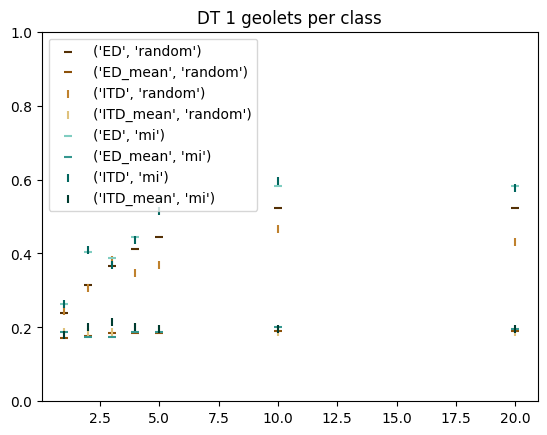

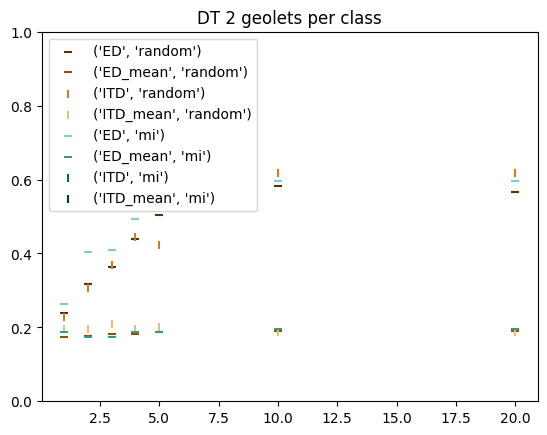

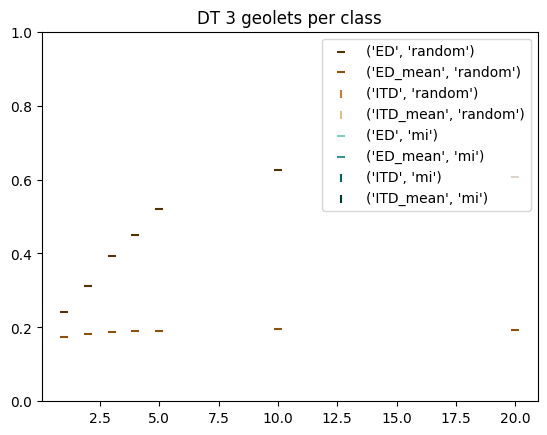

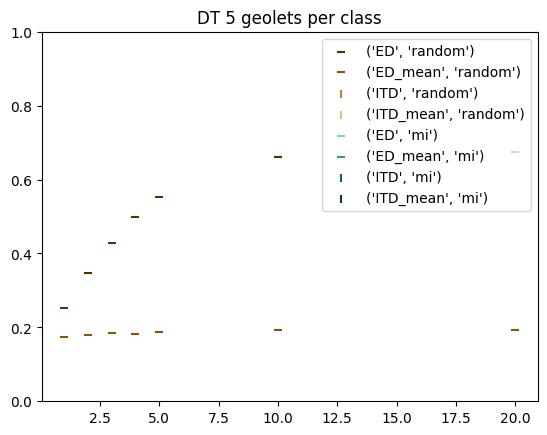

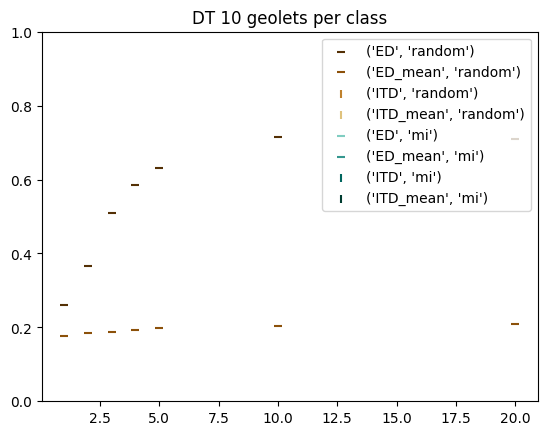

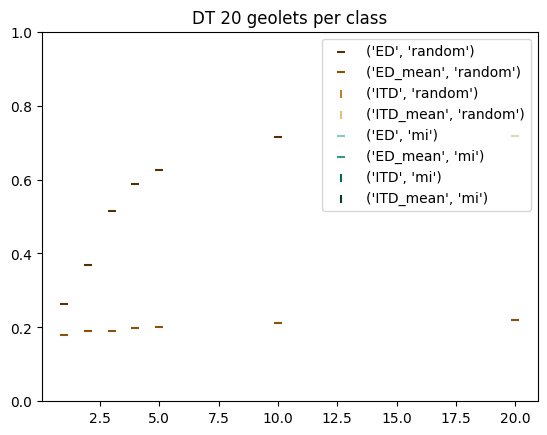

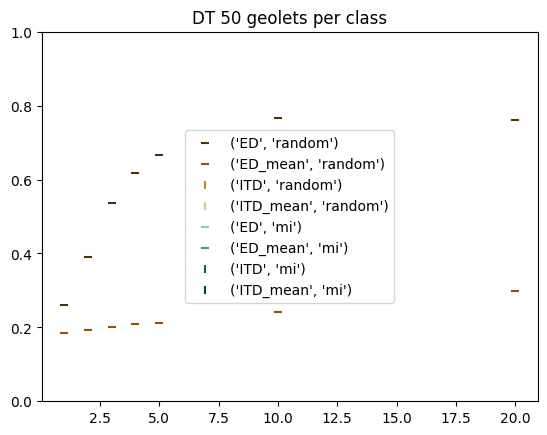

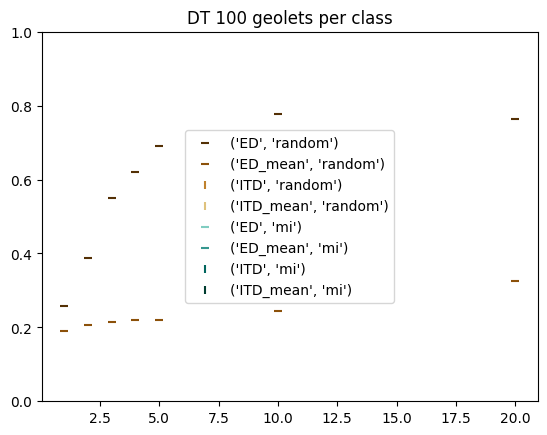

In [61]:
from matplotlib import pyplot as plt

model = "DT"
dataset = "sumo_all_car_vs_bikes"

x_axis_col = {
    "KNN": "n_neighbors",
    "DT": "max_depth",
    "RF": "n_estimators",
}

color_map={
    ('ED', 'random'): "#543005",
    ('ED_mean', 'random'): "#8c510a",
    ('ITD', 'random'): "#bf812d",
    ('ITD_mean', 'random'): "#dfc27d",
    
    ('ED', 'mi'): "#80cdc1",
    ('ED_mean', 'mi'): "#35978f",
    ('ITD', 'mi'): "#01665e",
    ('ITD_mean', 'mi'): "#003c30",
}


df_plot = df_grouped[(df_grouped.dataset_name == dataset) & (df_grouped.model == model)]

for n_geo_factor in df_grouped.n_geo_factor.unique():
    for selection in df.selection.unique():
        for distance in df_plot.distance.unique():
            plt.scatter(df_plot[(df_plot.distance == distance) & (df_plot.selection == selection) & (df_plot.n_geo_factor == n_geo_factor)][x_axis_col[model]], 
                        df_plot[(df_plot.distance == distance) & (df_plot.selection == selection) & (df_plot.n_geo_factor == n_geo_factor)].accuracy,
                        marker="_" if 'ED' in distance else '|', 
                        c=color_map[(distance, selection)],
                        label=f"{distance, selection}")
            
    plt.title(f"{model} {n_geo_factor} geolets per class")
            
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

In [49]:
df_plot

,dataset_name,trj_class,n_geo_factor,n_geo_,selection,distance,n_classes,max_depth,class_weight,model,...,recall_score,recall_micro,recall_macro,recall_weighted,roc_macro,roc_micro,roc_weighted,average_precision_macro,average_precision_micro,average_precision_weighted
8,sumo_all_car_vs_bikes,300,1,6,mi,ED,6,NaN,balanced,RF,...,0.666667,0.666667,0.666667,0.666667,0.909693,0.913720,0.909693,0.742497,0.752277,0.742497
9,sumo_all_car_vs_bikes,300,1,6,mi,ED,6,NaN,balanced,RF,...,0.652778,0.652778,0.652778,0.652778,0.917853,0.919652,0.917853,0.755910,0.762415,0.755910
10,sumo_all_car_vs_bikes,300,1,6,mi,ED,6,NaN,balanced,RF,...,0.652778,0.652778,0.652778,0.652778,0.917101,0.918764,0.917101,0.759351,0.763738,0.759351
11,sumo_all_car_vs_bikes,300,1,6,mi,ED,6,NaN,balanced,RF,...,0.659722,0.659722,0.659722,0.659722,0.918403,0.920279,0.918403,0.761578,0.764193,0.761578
23,sumo_all_car_vs_bikes,300,1,6,mi,ED_mean,6,NaN,balanced,RF,...,0.430556,0.430556,0.430556,0.430556,0.783999,0.769401,0.783999,0.423857,0.402531,0.423857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,sumo_all_car_vs_bikes,300,100,600,random,ED,6,NaN,balanced,RF,...,0.895139,0.895139,0.895139,0.895139,0.988322,0.989360,0.988322,0.952316,0.955416,0.952316
383,sumo_all_car_vs_bikes,300,100,600,random,ED_mean,6,NaN,balanced,RF,...,0.730556,0.730556,0.730556,0.730556,0.948079,0.949660,0.948079,0.820403,0.820753,0.820403
384,sumo_all_car_vs_bikes,300,100,600,random,ED_mean,6,NaN,balanced,RF,...,0.744444,0.744444,0.744444,0.744444,0.950848,0.952280,0.950848,0.826621,0.828279,0.826621
385,sumo_all_car_vs_bikes,300,100,600,random,ED_mean,6,NaN,balanced,RF,...,0.736806,0.736806,0.736806,0.736806,0.950116,0.952014,0.950116,0.823471,0.826027,0.823471
